# Approximate Factor Models, Vector Autoregression and Temporal Convolutional Networks from FRED-MD

We extract an approximate factor structure that reduces the number of dimensions (variables) in a large set of economic time series (FRED-MD), with number of components automatically selected by an information criterion and outliers replaced with an EM approach. 

We contrast Vector Autoregression and Temporal Convolutional Networks to model the time-series persistance of the extracted factors, and compare prediction errors.

- PCA, EM, vector autoregression, temporal convolutional networks
- Bai and Ng (2002), McCracken and Ng (2016), and others

Terence Lim

In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import os
import re
import time
from datetime import datetime
from finds.alfred import Alfred, fred_md, fred_qd
from finds.solve import integration_order
from settings import settings
imgdir = os.path.join(settings['images'], 'ts')
alf = Alfred(api_key=settings['fred']['api_key'])

## Load FRED-MD and FRED-QD

In [2]:
# Transformation Codes, and Stationarity
qdf, qt = fred_qd(202004)      # from vintage April 2020
mdf, mt = fred_md()

print('Number of time series and suggested transformations, by tcode:')
tcodes = pd.concat([Series(alf.tcode_[i], name=i).to_frame().T
                    for i in range(1,8)], axis=0).fillna(False)
tc = tcodes.join(qt['transform'].value_counts().rename('fred-qd'))\
           .join(mt['transform'].value_counts().rename('fred-md'))\
           .fillna(0).astype({'fred-qd': int, 'fred-md': int})

# Estimate and Compare Integration Order
out = {}
for label, df, t in [['md', mdf, mt], ['qd', qdf, qt]]:
    stationary = dict()
    for series_id, tcode in t['transform'].items():
        if tcode in [1, 2, 3, 4, 5, 6]:
            s = df[series_id] if tcode <= 3 else np.log(df[series_id])
            order = integration_order(s.dropna(), pvalue=0.05)
            stationary[series_id] = {
                'tcode': tcode,
                'I(p)': order,
                'different': '*' if (tcode - 1) % 3 != order else '',
                'title': alf.header(series_id)}
            #print(series_id, order, tcode)
    stationary = DataFrame.from_dict(stationary, orient='index')
    stationary = stationary.sort_values(stationary.columns.to_list())
    c = stationary.groupby(['tcode','I(p)'])['title'].count().reset_index()
    out[label] = c.pivot(index='tcode', columns='I(p)',
                         values='title').fillna(0).astype(int)
    out[label].columns=[f"I({p})" for p in out[label].columns]
print('Series by tcode, transformations and estimated order of integration:')
c = pd.concat([tc.drop(columns='fred-md'), out['qd'], tc['fred-md'], out['md']],
              axis=1).fillna(0).astype(int)
c

Number of time series and suggested transformations, by tcode:
Series by tcode, transformations and estimated order of integration:


,diff,log,pct_change,fred-qd,I(0),I(1),I(2),fred-md,I(0),I(1),I(2)
1,0,0,0,22,15,7,0,11,11,0,0
2,1,0,0,32,7,24,1,19,4,15,0
3,2,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,10,6,4,0
5,1,1,0,143,33,105,5,53,13,40,0
6,2,1,0,50,0,23,27,34,0,25,9
7,1,0,1,1,0,0,0,1,0,0,0


### Helper function to filter outliers

using common options based on percentiles (Tukey) or interquantile ranges

In [3]:
def as_inliers(x, method='iq10', bounds=False):
    """Returns boolean index indicating non-outliers in input series"""
    def nancmp(f, a, b):
        valid = ~np.isnan(a)
        valid[valid] = f(a[valid] , b)
        return valid

    x = np.array(x)
    if len(x.shape) == 1:
        lb, median, ub = np.nanpercentile(x, [25, 50, 75])
        if method.lower().startswith('tukey'):
            w = 1.5
            f = [lb - (w * (ub - lb)), ub + (w * (ub - lb))]
            if not bounds:
                f = (nancmp(np.greater_equal, x, f[0]) &
                     nancmp(np.less_equal, x, f[1]))
        elif method.lower() in 'iq10':
            w = float(re.sub('\D', '', method))
            f = [median - (w * (ub - lb)), median + (w * (ub - lb))]
            if not bounds:
                f = (nancmp(np.greater_equal, x,f[0]) &
                     nancmp(np.less_equal, x, f[1]))
        else:
            raise Exception("outliers method not in ['iq10', 'tukey']")
        return np.array(f)
    else:
        return np.hstack([as_inliers(x[:, i], method=method, bounds=bounds)\
                          .reshape(-1, 1) for i in range(x.shape[1])])


## Retrieve FRED-MD and apply tcode transformations

In [4]:
mdf, mt = fred_md() #201505
df = mdf.copy()
t = mt['transform']
beg = 19600301
end = 20991231
freq = 'm'
#df.head().append(df.tail())

# Apply tcode transformations
transformed = []
for col in df.columns:
    transformed.append(alf.transform(df[col], tcode=t[col], freq=freq))
data = pd.concat(transformed, axis=1).iloc[2:]
cols = list(data.columns)
sample = data.index[(data.index >= beg) & (data.index <= end)]
data

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPL,RETAIL,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENT,MZMSL,DTCOLNVHFNM,DTCTHFNM,INVEST,VXOCLS
19590331,0.006431,0.007374,0.009394,-0.003416,0.008321,0.014302,0.006034,0.004894,0.000000,0.019396,...,0.000261,-0.000022,-0.008147,0.004819,NaN,0.001066,0.004929,0.004138,-0.014792,NaN
19590430,0.006498,0.007019,-0.003576,0.019929,0.000616,0.021079,0.014341,0.014547,0.015655,0.006378,...,0.001835,-0.000022,0.012203,-0.004890,NaN,-0.002539,0.012134,0.006734,0.024929,NaN
19590531,0.005826,0.006629,0.011984,0.006796,0.007803,0.014951,0.008266,0.009581,0.004765,0.020152,...,-0.002019,-0.000021,-0.004090,-0.004819,NaN,0.004646,0.002828,0.002020,-0.015342,NaN
19590630,0.003108,0.003022,0.003646,-0.000027,0.009064,0.001141,0.007034,0.007127,-0.004765,0.007456,...,0.002087,-0.004619,0.003992,0.004796,0.0,-0.000760,0.009726,0.009007,-0.012252,NaN
19590731,-0.000586,-0.000808,-0.003365,0.012104,-0.000330,-0.024239,0.001168,0.008248,0.013056,0.019609,...,-0.000100,0.000000,-0.004040,-0.004796,0.0,-0.002158,-0.004631,-0.001000,0.029341,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20201130,-0.012452,-0.007142,-0.006493,-0.001800,-0.013646,0.008970,0.005644,0.006273,0.003317,0.016860,...,-0.001035,0.000766,-0.005511,0.005643,-4.9,0.003513,0.005337,0.004147,0.005019,24.8047
20201231,0.001746,-0.001470,-0.009289,-0.002161,-0.012259,0.010134,0.012165,0.012001,0.017048,0.003616,...,0.003724,-0.001182,-0.002048,-0.003908,3.8,-0.000988,-0.008388,-0.003187,-0.009482,21.6803
20210131,0.095084,-0.001143,0.030135,0.031772,0.072834,0.009264,0.006152,0.006995,-0.000355,0.018115,...,-0.002587,-0.000010,-0.001356,0.002589,-1.7,0.003723,0.012255,0.008321,0.004091,23.7684
20210228,-0.074866,0.002849,-0.012506,-0.032977,-0.029171,-0.026560,-0.016146,-0.013648,-0.008979,-0.064997,...,0.000788,-0.004648,-0.001685,-0.001301,-2.2,-0.011852,-0.010334,-0.008692,-0.004717,21.3570


## Filter outliers and summarize missing and outliers

In [13]:
outlier, missing = [], []    # to accumulate outlier and missing obs
for series_id in df.columns:
    f = as_inliers(data[series_id], method='iq10')
    g = data[series_id].notna()
    missing.extend([(date, series_id) for date in data.index[~g]])
    outlier.extend([(date, series_id, data.loc[date, series_id])
                    for date in data.index[~f & g]])
missing_per_row = data.isna().sum(axis=1)
outlier = DataFrame.from_records(outlier,
                                 columns=['date', 'series_id', 'value'])
missing = DataFrame.from_records(missing, columns=['date', 'series_id'])    
outlier['date'].value_counts()[:10]
    
n = 10
out = pd.concat([outlier['date'].value_counts()[:n],
                 outlier['series_id'].value_counts()[:n],
                 missing['date'].value_counts()[:n],
                 missing['series_id'].value_counts()[:n]])
from finds.printing import print_multicolumn
print_multicolumn(out, rows=n)



20200430          38  NONBORRES         14  19590531          10  ACOGNO           396
20200531          11  FEDFUNDS          10  19590430          10  TWEXAFEGSMTH     167
20200630          10  CP3M               7  19590331          10  ANDENO           108
19800531           5  CES1021000001      6  19590831           9  VXOCLS            40
20200331           5  RPI                6  19590731           9  PERMITNE          10
19800331           4  TB3MS              6  19590630           9  PERMITMW          10
19811130           4  DTCOLNVHFNM        5  19591231           9  PERMITS           10
20200731           3  CONSPI             4  19590930           9  PERMITW           10
19820831           3  DTCTHFNM           4  19591031           9  PERMIT            10
19801130           3  NONREVSL           4  19591130           9  UMCSENT            3


## PCA EM Algorithm

Extract approximate factor, with outliers and removed replaced through an EM approach. The information criterion picked 8 factors

- Bai and Ng (2002)

In [19]:
from finds.alfred import pcaEM, BaiNg, marginalR2
X = np.array(data.loc[sample])
X[~as_inliers(X, method='iq10')] = np.nan    # missing and outliers to NaN
x, model = pcaEM(X, kmax=None, p=2, tol=1e-21, echo=False)
r = BaiNg(x, p=2, standardize=True)
mR2 = marginalR2(x, standardize=True)
print(f"Explained by {r} factors: {np.sum(np.mean(mR2[:r,:], axis=1)):.3f}"
      f" ({len(x)} obs: {min(sample)}-{max(sample)})")
econ = []
for k in range(r):
    print()
    print(f"Factor:{1+k:2d}  Variance Explained={np.mean(mR2[k, :]):6.3f}")
    args = np.argsort(-mR2[k, :])
    for i, arg in enumerate(args[:10]):
        print(f"{mR2[k, arg]:6.3f} {cols[arg]:16s} {alf.header(cols[arg])}")
    econ.append(Series(data=x[:,args[0]], name=cols[args[0]],
                       index=pd.DatetimeIndex(sample.astype(str), freq='infer')))
econ = pd.concat(econ, axis=1)
econ = econ.sub(econ.mean()).div(econ.std(ddof=0))  # standardize

Explained by 8 factors: 0.507 (733 obs: 19600331-20210331)

Factor: 1  Variance Explained= 0.174
 0.813 IPMANSICS        Industrial Production: Manufacturing (SIC)
 0.799 PAYEMS           All Employees, Total Nonfarm
 0.763 INDPRO           Industrial Production: Total Index
 0.763 IPFPNSS          Industrial Production: Final Products and Nonindustrial Supplies
 0.754 USGOOD           All Employees, Goods-Producing
 0.751 CUMFNS           Capacity Utilization: Manufacturing (SIC)
 0.702 IPFINAL          Industrial Production: Final Products
 0.700 MANEMP           All Employees, Manufacturing
 0.664 IPDMAT           Industrial Production: Durable Goods Materials
 0.647 IPBUSEQ          Industrial Production: Equipment: Business Equipment

Factor: 2  Variance Explained= 0.074
 0.413 CUSR0000SAC      Consumer Price Index for All Urban Consumers: Commodities in U.S. City Average
 0.396 CUSR0000SA0L2    Consumer Price Index for All Urban Consumers: All Items Less Shelter in U.S. City Aver

##  Extract Approximate Factors via numpy SVD

In [20]:
y = ((x-x.mean(axis=0).reshape(1,-1))/x.std(axis=0,ddof=0).reshape(1,-1))
u, s, vT = np.linalg.svd(y, full_matrices=False)
factors = DataFrame(u[:, :r], columns=np.arange(1, 1+r),
                    index=pd.DatetimeIndex(sample.astype(str), freq='infer'))
Series(s[:r]**2 / np.sum(s**2), index=np.arange(1, r+1), name='R2').to_frame().T

,1,2,3,4,5,6,7,8
R2,0.174099,0.074272,0.068588,0.05395,0.04832,0.033442,0.029557,0.024684


## Equivalently with sklearn PCA

In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
pipe = Pipeline([('scaler', StandardScaler()), ('pca', PCA(r))])
pipe.fit(x)   # fit model on training data
Series(pipe.named_steps['pca'].explained_variance_ratio_,
       index=np.arange(1,r+1), name='R2').to_frame().T   # sanity check

,1,2,3,4,5,6,7,8
R2,0.174099,0.074272,0.068588,0.05395,0.04832,0.033441,0.029557,0.024684


## Retrieve recession periods from FRED

In [22]:
usrec = alf('USREC', freq=freq)
usrec.index = pd.DatetimeIndex(usrec.index.astype(str), freq='infer')
g = (usrec != usrec.shift()).cumsum()[usrec.gt(0)].to_frame()
g = g.reset_index().groupby('USREC')['date'].agg(['first','last'])
vspans = [(v[0], v[1]) for k, v in g.iterrows()]
print(alf.header('USREC'))
DataFrame(vspans, columns=['Start', 'End'])

NBER based Recession Indicators for the United States from the Period following the Peak through the Trough


,Start,End
0,1854-12-31,1854-12-31
1,1857-07-31,1858-12-31
2,1860-11-30,1861-06-30
3,1865-05-31,1867-12-31
4,1869-07-31,1870-12-31
5,1873-11-30,1879-03-31
6,1882-04-30,1885-05-31
7,1887-04-30,1888-04-30
8,1890-08-31,1891-05-31
9,1893-02-28,1894-06-30


## Plot extracted factors alongside recession periods

Visually, there are some differences across recession periods in how factors respond

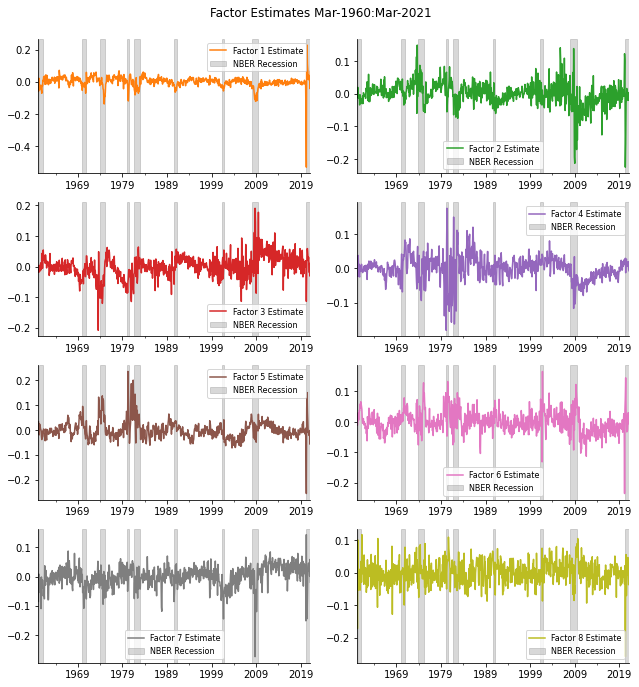

In [23]:
fig = plt.figure(figsize=(9, 10), num=1, clear=True)
for col in factors.columns:
    ax = fig.add_subplot(4, 2, col)
    flip = -np.sign(max(factors[col]) + min(factors[col])) # try match sign
    (flip*factors[col]).plot(ax=ax, color=f"C{col}")
    for a,b in vspans:
        ax.axvspan(a, b, alpha=0.3, color='grey')
    ax.legend([f"Factor {col} Estimate", 'NBER Recession'], fontsize=8)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle(f"Factor Estimates {factors.index[0]:%b-%Y}:"
             f"{factors.index[-1]:%b-%Y}", fontsize=12)
plt.savefig(os.path.join(imgdir, 'approximate.jpg'))
plt.show()

# Vector Autoregression Model of the Extracted Factors

predicting composites of, rather than individual, macroeconomic time series

In [24]:
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from finds.display import plot_bands

test_date = '2014-12-31'
train_data = factors[factors.index <= test_date].copy()
maxlags = 16
test_data = factors[(factors.index >= train_data.index[-maxlags]) &
                    (factors.index <= '2019-12-31')].copy() 
M = train_data.shape[1]
model = VAR(train_data)

## Selecting lag order

With different information criteria

In [25]:
results = {p: model.fit(p) for p in [1, 2, 4, 12]}   # VAR(p) models
DataFrame({ic: model.fit(maxlags=maxlags, ic=ic).k_ar
           for ic in ['aic', 'fpe', 'hqic', 'bic']},
          index=['lag order selected by:'])\
          .rename_axis(columns='Information Criterion:')

Information Criterion:,aic,fpe,hqic,bic
lag order selected by:,4,4,3,2


## Extract and plot impulse response function with confidence bands

The lagged coefficients estimated from the Vector Autoregression produce a multi-period cumulative forecast

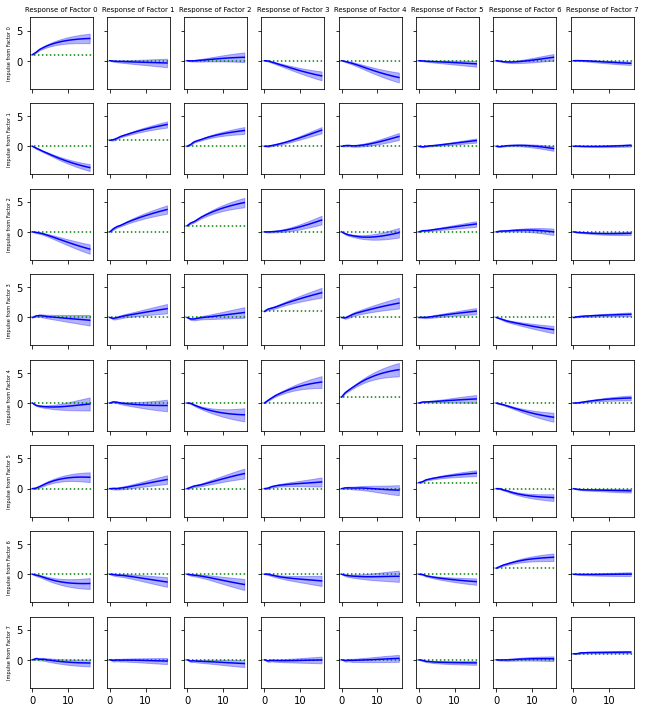

In [26]:
irf = results[2].irf(maxlags)
fig, axes = plt.subplots(M, M, figsize=(9,10), num=1, clear=True,
                         sharex=True, sharey=True)
for impulse in range(M):
    for response in range(M):
        plot_bands(mean=irf.cum_effects[:, impulse, response],
                   stderr=irf.cum_effect_stderr()[:, impulse, response],
                   hline=1 if impulse == response else 0,
                   title=None if impulse else f"Response of Factor {response}",
                   ylabel=None if response else f"Impulse from Factor {impulse}",
                   fontsize=3, ax=axes[impulse, response])
plt.tight_layout()
plt.savefig(os.path.join(imgdir, 'impulse.jpg'))
plt.show()

## Collect one-period ahead forecasts and errors in train and test sets


In [27]:
from sklearn.metrics import mean_squared_error as mse
mean_error = dict()
var_error= {p: dict() for p in results}
for x in [train_data, test_data]:
    for i in range(maxlags, len(x)):
        # error of unconditional mean forecast
        mean_error[x.index[i]] = mse(x.iloc[i].values, train_data.mean().values)
        
        # error VAR(p) model forecasts
        for p in var_error:
            pred = results[p].forecast(x.iloc[(i-p):i].values, 1)
            var_error[p][x.index[i]] = mse([x.iloc[i].values], pred)

## Compute mean test and train set errors of all models

Unsurprisingly, lower training errors with greater lag orders, but test error minimized around p=2

In [28]:
mean_error = Series(mean_error, name="TrainMean")
out = [Series({'Train Error': mean_error.loc[mean_error.index<=test_date].mean(),
               'Test Error': mean_error.loc[mean_error.index>test_date].mean()},
              name=mean_error.name)]
var_error = {p: Series(var_error[p], name=f"VAR({p})") for p in var_error}
for p, e in var_error.items():
    out.append(Series({'Train Error': e.loc[e.index<=test_date].mean(),
                       'Test Error': e.loc[e.index>test_date].mean()},
                      name=e.name))
out = pd.concat(out, axis=1).T.rename_axis(columns="1961-07-31...2019-12-31:")\
                           .rename_axis(index=f"(Test-split={test_date})")
out

1961-07-31...2019-12-31:,Train Error,Test Error
(Test-split=2014-12-31),,
TrainMean,0.001274,0.000722
VAR(1),0.000762,0.000545
VAR(2),0.000709,0.000481
VAR(4),0.000660,0.000486
VAR(12),0.000549,0.000498


## Plot monthly mean squared error

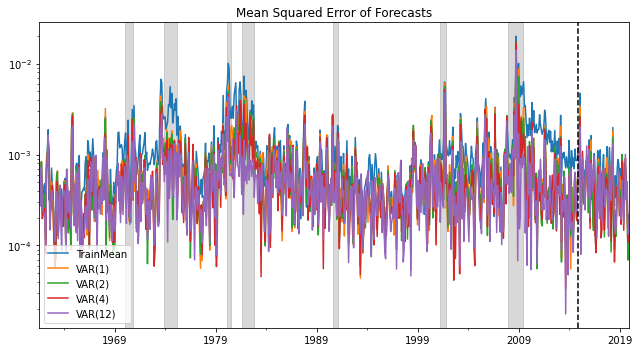

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(9, 5), num=1, clear=True)
ax.set_yscale('log')
mean_error.plot(ax=ax, c='C0', style='-')
for i, (p, v) in enumerate(var_error.items()):
    v.plot(ax=ax, c=f'C{i+1}', style='-')
for a,b in vspans:
    ax.axvspan(a, b, alpha=0.3, color='grey')
ax.set_title('Mean Squared Error of Forecasts')
ax.axvline(test_date, color='black', linestyle='--')
ax.legend(loc='lower left')
plt.tight_layout()
plt.savefig(os.path.join(imgdir, 'varmse.jpg'))
plt.show()

# Temporal 1D Convolutional Net (TCN)

Instead of VAR, model the factor time series with TCN

In [30]:
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class TCN(torch.nn.Module):
    class CausalConv1dBlock(torch.nn.Module):
        """Building block Conv1d, ReLU, skip, dropout, dilation and padding"""
        def __init__(self, in_channels, out_channels, kernel_size, dilation,
                     dropout):
            super().__init__()
            self.network = torch.nn.Sequential(
                torch.nn.ConstantPad1d(((kernel_size-1)*dilation, 0), 0),
                torch.nn.Conv1d(in_channels, out_channels, kernel_size,
                                dilation=dilation),
                torch.nn.ReLU(),
                torch.nn.ConstantPad1d(((kernel_size-1)*dilation, 0), 0),
                torch.nn.Conv1d(out_channels, out_channels, kernel_size,
                                dilation=dilation),
                torch.nn.ReLU(),
                torch.nn.Dropout(dropout))
            self.skip = lambda x: x
            if in_channels != out_channels:     # downsample if necessary
                self.skip = torch.nn.Conv1d(in_channels, out_channels,1)

        def forward(self, x):
            return self.network(x) + self.skip(x)  # with skip connection


    def __init__(self, n_features, layers=[8, 8, 8], kernel_size=3, dropout=0.0):
        """TCN model by connecting multiple convolution layers"""
        super().__init__()
        c = n_features
        L = []
        for total_dilation, l in enumerate(layers):
            L.append(self.CausalConv1dBlock(in_channels=c,
                                            out_channels=l,
                                            kernel_size=kernel_size,
                                            dilation=2*(total_dilation+1),
                                            dropout=dropout))
            c = l
        self.network = torch.nn.Sequential(*L)
        self.classifier = torch.nn.Conv1d(c, n_features, 1)

    def forward(self, x):
        """input is (B, n_features, L)), linear expects (B, * n_features)"""
        return self.classifier(self.network(x))

    def save(self, filename):
        """save model state to filename"""
        return torch.save(self.state_dict(), filename)

    def load(self, filename):
        """load model name from filename"""
        self.load_state_dict(torch.load(filename, map_location='cpu'))
        return self


## Create input data from training set

In [31]:
seq_len = 16    # length of each sequence for TCN
train_exs = [train_data.iloc[i-(seq_len+1):i].values
             for i in range(seq_len+1, len(train_data))]
n_features = train_data.shape[1]

## Fit TCN models with increasing layers of convolution and dropout

We experiment with two of the many choices of hyperparameters

In [33]:
max_layers = 4       # range of convolution block depths
dropouts = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]   # range of dropout rates
lr = 0.01            # initial learning rate
step_size = 300      # learning rate scheduler step size
res = []             # to collect results summaries
tcn_error = dict()   # to store prediction errors
for layers in range(1, max_layers+1):
    for dropout in dropouts:
        model = TCN(n_features, layers=[16]*layers, kernel_size=2,
                    dropout=dropout).to(device)
        #print(model)

        # Set optimizer, loss and learning rate scheduler
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=0.1,
                                                    step_size=step_size)
        loss_function = nn.MSELoss()

        # Run training loop over num_epochs with batch_size
        batch_size = 8
        num_epochs = step_size*6
        for epoch in range(num_epochs):
    
            # shuffle indxs into batches
            idxs = np.arange(len(train_exs))
            random.shuffle(idxs)
            batches = [idxs[i:(i+batch_size)]
                       for i in range(0, len(idxs), batch_size)]
            batch = batches[0]
    
            # train by batch
            total_loss = 0.0
            model.train()
            for batch in batches:
                # input has shape (batch_size=8, n_features=8, seq_len=16)
                train_ex = torch.tensor([[train_exs[idx][seq] for idx in batch]
                                         for seq in range(seq_len+1)])\
                                .permute(1,2,0).float().to(device)
                model.zero_grad()
                X = train_ex[:,:,:-1]
                Y = train_ex[:,:,1:]
                output = model(X)
                loss = loss_function(output, Y)  # calculated over all outputs
                total_loss += float(loss)
                loss.backward()
                optimizer.step()
            scheduler.step()
            #if (epoch % (step_size//2)) == 0:
            #    print(epoch, layers, dropout, optimizer.param_groups[0]['lr'],
            #          total_loss/len(batches))
            model.eval()

        # Compute MSE of one-period ahead forecast error in train and test sets
        e = dict()
        for x in [train_data, test_data]:
            for i in range(seq_len, len(x)):
                X = torch.tensor(x.iloc[(i-seq_len):i].values.T)\
                         .unsqueeze(0).float().to(device)
                pred = model(X)
                e[x.index[i]] = mse([x.iloc[i].values],
                                    pred[:,:,-1].cpu().detach().numpy())
        name=f"TCN{layers}_{dropout*100:.0f}"
        model.save(os.path.join(imgdir, name + '.pt'))
        e = Series(e, name=name)
        tcn_error[name] = e
        res.append(Series({'depth': layers, 'dropout': dropout,
                           'Train Error': float(e[e.index<=test_date].mean()),
                           'Test Error': float(e[e.index>test_date].mean())},
                          name=name))
        #print(pd.concat(res, axis=1).T)
res = pd.concat(res, axis=1).T
model

TCN(
  (network): Sequential(
    (0): CausalConv1dBlock(
      (network): Sequential(
        (0): ConstantPad1d(padding=(2, 0), value=0)
        (1): Conv1d(8, 16, kernel_size=(2,), stride=(1,), dilation=(2,))
        (2): ReLU()
        (3): ConstantPad1d(padding=(2, 0), value=0)
        (4): Conv1d(16, 16, kernel_size=(2,), stride=(1,), dilation=(2,))
        (5): ReLU()
        (6): Dropout(p=0.5, inplace=False)
      )
      (skip): Conv1d(8, 16, kernel_size=(1,), stride=(1,))
    )
    (1): CausalConv1dBlock(
      (network): Sequential(
        (0): ConstantPad1d(padding=(4, 0), value=0)
        (1): Conv1d(16, 16, kernel_size=(2,), stride=(1,), dilation=(4,))
        (2): ReLU()
        (3): ConstantPad1d(padding=(4, 0), value=0)
        (4): Conv1d(16, 16, kernel_size=(2,), stride=(1,), dilation=(4,))
        (5): ReLU()
        (6): Dropout(p=0.5, inplace=False)
      )
    )
    (2): CausalConv1dBlock(
      (network): Sequential(
        (0): ConstantPad1d(padding=(6, 0), 

## Plot monthly mean squared error

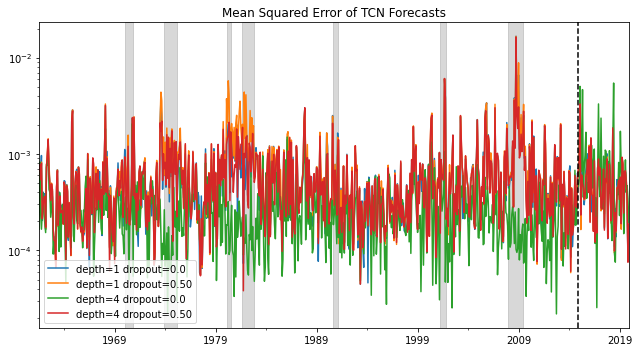

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(9, 5), num=1, clear=True)
ax.set_yscale('log')
legend = []
for i, layers in enumerate([1, 4]):
    for j, dropout in enumerate([0, 50]):
        tcn_error[f"TCN{layers}_{dropout}"].plot(ax=ax, c=f'C{i*2+j}')
        legend.append(f"depth={layers} dropout=0.{dropout}")
for a,b in vspans:
    ax.axvspan(a, b, alpha=0.3, color='grey')
ax.set_title('Mean Squared Error of TCN Forecasts')
ax.axvline(test_date, color='black', linestyle='--')
ax.legend(legend, loc='lower left')
plt.tight_layout()
plt.savefig(os.path.join(imgdir, 'tcnmse.jpg'))
plt.show()

## Display train and test error of TCN models by dropout and depth parameters
- Train errors decreasing by depth and increasing by dropout
- Test errors (weakly) increasing by depth and decreasing by dropout 
- Althought TCN could achieve lower training errors than VAR, test errors were larger than the more constrained/regularized method.

In [35]:
res.astype({'depth':int})\
    .pivot(index=['dropout'], columns=['depth'],
                 values=['Train Error','Test Error'])\
    .swaplevel(0, 1, 1).sort_index(axis=1)

depth            1                      2                      3              \
        Test Error Train Error Test Error Train Error Test Error Train Error   
dropout                                                                        
0.0       0.000569    0.000662   0.000541    0.000476   0.000793    0.000372   
0.1       0.000575    0.000534   0.000582    0.000405   0.000718    0.000412   
0.2       0.000639    0.000593   0.000558    0.000528   0.000777    0.000422   
0.3       0.000545    0.000592   0.000586    0.000614   0.000551    0.000574   
0.4       0.000548    0.000762   0.000548    0.000762   0.000549    0.000682   
0.5       0.000548    0.000762   0.000548    0.000762   0.000548    0.000762   

depth            4              
        Test Error Train Error  
dropout                         
0.0       0.000902    0.000284  
0.1       0.000655    0.000347  
0.2       0.000728    0.000428  
0.3       0.000581    0.000590  
0.4       0.000548    0.000569  
0.5       0.000547    0.000647

## Plot Train and Test Error of TCN Models

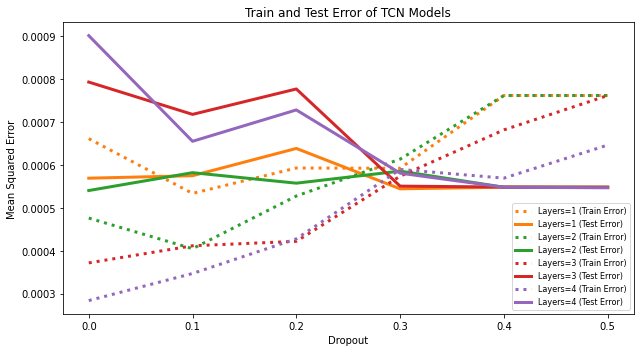

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(9, 5), num=1, clear=True)
for layers in np.unique(res.depth):
    for err, style in zip(['Train Error', 'Test Error'], [':','-']):
        select = res['depth'].eq(layers)
        Series(index=res['dropout'][select], data=res[err][select].values,
               name=f"Layers={layers:.0f} ({err})")\
               .plot(ax=ax, color=f"C{layers:.0f}", style=style, lw=3)
ax.set_title('Train and Test Error of TCN Models')
ax.set_ylabel('Mean Squared Error')
ax.set_xlabel('Dropout')
ax.legend(loc='lower right', fontsize=8)
plt.tight_layout()
plt.savefig(os.path.join(imgdir, 'tcn.jpg'))
plt.show()